## Введение в анализ данных, ИАД-4

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнил: _Хайкин Глеб_

### О задании

В этом домашнем задании вы реализуете алгоритм kNN и линейную регрессию, попрактикуетесь в решении задачи регрессии, а также решите теоретические задачи.

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / 18,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 18, а максимальное число дополнительных баллов, которые пойдут в бонус — 2. Бонусные задания отмечены звездочками (*).

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

# kNN своими руками (5)

В этом задании вам предстоит реализовать взвешенный алгоритм kNN для регрессии. Пусть необходимо вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

### Реализуйте две функции расстояния (1 балл)
- Евклидова метрика **(0.5 балла)**
- Метрика Манхэттена **(0.5 балла)**

Обе функции должны на вход получать матрицу `np.array of shape(n, m)` и вектор `np.array of shape(m,)`, а возвращать вектор расстояний от каждой строчки матрицы до вектора `np.array of shape(n,)`

**В данном пункте запрещено использование циклов for, while. Пользуйтесь возможностями numpy.** 

In [1]:
import numpy as np

In [2]:
def euclidian_metric(X, x):
    distances = np.sqrt(np.sum((X - x) ** 2, axis=1))
    return distances

def manhattan_metric(X, x):
    distances = np.sum(abs(X - x), axis=1)
    return distances

In [3]:
# Проверка
X = np.array([[1, 2, 3], [5, 6, 7], [8, 9, 10]])
y = np.ones(3)

assert np.allclose(euclidian_metric(X, y), np.array([ 2.23606798,  8.77496439, 13.92838828]))
assert np.allclose(manhattan_metric(X, y), np.array([ 3., 15., 24.]))

### Реализуйте алгоритм kNN для регрессии (4 балла)

- Реализуйте класс kNN для равномерных весов (то есть $w_1 = \ldots = w_k$) **(3 балла)**
- Добавьте возможность передать данному классу параметр `weights='distance'` для вызова взвешенной версии алгоритма kNN (то есть $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$ **(1 балл)**

In [4]:
class KNN:
    def __init__(self, metric='euclid', k=5, weights='uniform'):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        weights ('uniform' or 'distance')
        """

        self.metric = metric
        self.k = k
        self.weights = weights
        
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        """

        # Запоминаем обучающу выборку
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        
        y_pred = np.asarray([])
        for row in X_test:
            x = np.array(row)
            if self.metric == 'euclid':
                distances = euclidian_metric(X_train, x)
            elif self.metric == 'manhattan':
                distances = manhattan_metric(X_train, x)
                
            # Каждому расстоянию даем номер и потом сортируем по возрастанию, оставляя только k наименьших расстояний
            k_distances = sorted(enumerate(distances), key=lambda x: x[1])[:self.k]
            # Вытаскиваем номера k-ближайших объектов к новому объекту x
            indices = [i[0] for i in k_distances]
            # Целевая переменная k-ближайших объектов 
            y_near = np.take(y_train, indices)

            if self.weights == 'uniform':
                a = np.mean(y_near)
                y_pred = np.append(y_pred, a)
            if self.weights == 'distance':
                weights = np.asarray([])
                for dist in sorted(distances)[:self.k]:
                    # Определяем веса для каждого i-го объекта
                    weights = np.append(weights, 1 / dist)
                a = np.sum(weights * y_near) / np.sum(weights)
                y_pred = np.append(y_pred, a)
                
        return y_pred

Сверьте для нескольких комбинаций различных гиперпараметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn`. **Не забудьте про гиперпараметр `weights`.**

In [5]:
np.random.seed(13)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [6]:
from sklearn.neighbors import KNeighborsRegressor

Так как мы решаем задачу регрессии, для измерения функционала ошибки воспользуемся MSE.

In [7]:
from sklearn.metrics import mean_squared_error

1. Возьмем евклидово расстояние, k = 5 и равномерные веса

Наша реализация:

In [8]:
knn_reg = KNN()

In [9]:
knn_reg.fit(X_train, y_train)

In [10]:
predictions = knn_reg.predict(X_test)

In [11]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.2508868032916385


Алгоритм из `sklearn`:

In [12]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [13]:
predictions = knn_reg.predict(X_test)

In [14]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.2508868032916385


2. Возьмем евклидово расстояние, k = 5 и веса, зависящие от расстояния (`weights='distance'`)

In [15]:
knn_reg = KNN(weights='distance')

In [16]:
knn_reg.fit(X_train, y_train)

In [17]:
predictions = knn_reg.predict(X_test)

In [18]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.2511100369876107


Алгоритм из `sklearn`:

In [19]:
knn_reg = KNeighborsRegressor(weights='distance')
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

In [20]:
predictions = knn_reg.predict(X_test)

In [21]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.2511100369876107


3. Возьмем метрику Манхэттена, k = 15 и веса, зависящие от расстояния (`weights='distance'`)

In [22]:
knn_reg = KNN(metric='manhattan', k=15, weights='distance')

In [23]:
knn_reg.fit(X_train, y_train) 

In [24]:
predictions = knn_reg.predict(X_test)

In [25]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.153011289816226


Алгоритм из `sklearn`:

In [26]:
knn_reg = KNeighborsRegressor(n_neighbors=15, p=1, weights='distance')
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                    weights='distance')

In [27]:
predictions = knn_reg.predict(X_test)

In [28]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.1530112898162261


# Линейная регрессия своими руками (5)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

*Чему будет равен градиент этой функции по $w$? Вспомните, что за вектор $\hat{y}$ и как он зависит от $X$ и $w$.*

__Решение__:

$\hat{y}~=~<w,x>$

Определим градиент в матричной форме: 

1) Eсли $|y - \hat{y}| \leq \delta$

$$Q(w) = \frac{1}{2}(y - Xw)^T(y -Xw) \to \min_{w} \limits$$

Тогда

$$\nabla_w Q(w) = \frac{1}{2}\nabla_w[y^Ty - y^TXw - w^TX^Ty + w^TX^TXw] = \frac{1}{2}[- X^Ty - X^Ty + (X^TX + X^TX)w] = -X^Ty + X^TXw = X^T(Xw - y)$$

2) Eсли $|y - \hat{y}| > \delta$

$$Q(w) = \delta|y - Xw| - \frac{1}{2}\delta^2  \to \min_{w} \limits$$



Пусть $u = y - Xw$, тогда $|u|= \sqrt{u^2}$ и, следовательно,

$$
\nabla_w Q(w) 
=
    \delta \dfrac{1}{2\sqrt{u^2}} 2u \dfrac{\partial}{\partial w}(y - Xw) = \delta \dfrac{-Xu}{|u|} = \delta \dfrac{-X(y - Xw)}{|y - Xw|} 
$$

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'
%matplotlib inline

### Реализуйте функцию потерь Хьюбера для одного примера и ее градиент по весам (1.5 балла)

- Функция потерь **(0.5 балла)**
- Градиент **(1 балл)**

**В данном пункте запрещено использование циклов for, while. Пользуйтесь возможностями numpy. Однако можно использовать оператор if.**

In [2]:
def huber_loss(x, y, w, delta):
    """
    x - np.array shape=(d,)
    y - scalar
    w - np.array shape=(d,)
    delta - scalar
    
    OUTPUT:
    loss - scalar
    """
    if abs(y - np.sum(x * w)) <= delta:
        return (y - np.sum(x * w)) ** 2 / 2
    else:
        return delta * abs(y - np.sum(x * w)) - delta ** 2 / 2
        

def huber_grad(x, y, w, delta):
    """
    INPUT:
    x - np.array shape=(d,)
    y - scalar
    w - np.array shape=(d,)
    delta - scalar
    
    OUTPUT:
    grad - np.array shape=(d,)
    """
    if abs(y - np.sum(x * w)) <= delta:
        return np.transpose(x) * (np.sum(x * w) - y)
    else:
        return delta * (-x) * (y - np.sum(x * w)) / abs(y - np.sum(x * w))

In [31]:
# Проверка

x = np.array([1, 2, 3])
w = np.array([3, 5, 12])
y = 19
delta = 1

assert huber_loss(x, y, w, delta) == 29.5
assert np.allclose(huber_grad(x, y, w, delta), np.array([1, 2, 3]))

y = 49.2

assert np.allclose(huber_loss(x, y, w, delta), 0.02000000000000057)
assert np.allclose(huber_grad(x, y, w, delta), np.array([-0.2, -0.4, -0.6]))

### Реализуйте линейную регрессию (3.5 балла)

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [32]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        """
        PARAMETERS:
        delta - scalar in Huber loss
        max_iter - maximum possible number of iterations in Gradient Descent
        tol - precision for stopping criterion in Gradient Descent
        eta - step size in Gradient Descent (learning rate)
        """

        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        
        self.w = None
        self.loss_history = None
        
    def fit(self, X, y):
        """
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        
        В этой функции вы должны инициализировать веса (можно нулями), а также 
        итерационно обновлять веса с помощью 
        градиентного спуска (считать и запоминать лосс (значение функции потерь) будет хорошим решением)
        """
        
        # Инициализируем веса нулями 
        self.w = np.zeros(X.shape[1])
        self.loss_history = []

        for i in range(self.max_iter):
            grad = self.calc_gradient(X, y)
            self.w = self.w - self.eta * grad
            self.loss_history.append(self.calc_loss(X, y))

            # Используем евклидову норму для определения остановки GD
            if np.sqrt(np.sum(grad) ** 2) <= self.tol:
                break
            
        return self.loss_history
        
    def predict(self, X):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        
        Предскажите ответы с помощью обученных весов
        """
        
        y_pred = np.sum(X * self.w, axis=1)

        return y_pred
    
    def calc_gradient(self, X, y):
        """
        Calculates the gradient of Huber loss by weights.
        
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        
        OUTPUT:
        grad - np.array of shape (d,)
        
        Посчитайте градиент как среднее от градиентов для каждого примера
        """
        
        # Видоизменил inputs: берем всю выборку, а не один объект, так как нас просят
        # посчитать градиент как среднее от градиентов для каждого примера — то есть делаю это здесь, а не в fit
        
        grad = np.zeros_like(self.w)
        
        for idx, row in enumerate(X):
            features = np.array(row)
            grad += huber_grad(features, y[idx], self.w, self.delta)
            
        return grad / X.shape[0]
    
    def calc_loss(self, X, y):
        """
        Calculates the Huber loss.
        
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        
        OUTPUT:
        loss - float
        
        Посчитайте loss по выборке как среднее loss'ов для каждого 
        примера
        """
        
        # Видоизменил inputs: берем всю выборку, а не один объект, так как нас просят
        # посчитать градиент как среднее от градиентов для каждого примера — то есть делаю это здесь, а не в fit
        
        loss = 0
        
        for idx, row in enumerate(X):
            features = np.array(row)
            loss += huber_loss(features, y[idx], self.w, self.delta)
            
        return loss / X.shape[0]

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

1. Наша реализация:

In [33]:
lrh = LinearRegressionHuber()
loss_history = lrh.fit(X_train, y_train)

Оптимальные веса выглядят следующим образом:

In [34]:
lrh.w

array([-0.01312873, -0.00492557, -0.01126661,  0.02993363,  0.07109251,
        0.00944865, -0.00013538, -0.00905035, -0.02140454,  0.00096639,
        0.05952053, -0.0264112 ,  0.00880743, -0.08250275,  0.04253728,
        0.03585687,  0.02643106,  0.05503536,  0.01326911,  0.00873247,
       -0.00553887,  0.00067983,  0.01495506,  0.08084855,  0.01615364,
        0.05069218,  0.02584807,  0.06395556, -0.0588596 , -0.01404283,
        0.04967637, -0.00722718,  0.01516255,  0.03348865,  0.04002638,
        0.01559124, -0.03227637,  0.00706896,  0.02626936,  0.00805372,
        0.0433774 , -0.05179749,  0.03996879, -0.01291109, -0.01920221,
        0.04816954,  0.01485132, -0.00027299, -0.0606412 ,  0.00420868])

Прогноз:

In [35]:
predictions = lrh.predict(X_test)

MSE:

In [36]:
print('MSE:', mean_squared_error(y_test, predictions))

MSE: 1.162473921866465


Huber loss:

In [37]:
print('Huber loss:', lrh.calc_loss(X_test, y_test))

Huber loss: 0.4827342823832491


2.

Построим график зависимости значения функции потерь от итерации градиентного спуска.

Text(0.5, 0, 'GD iteration')

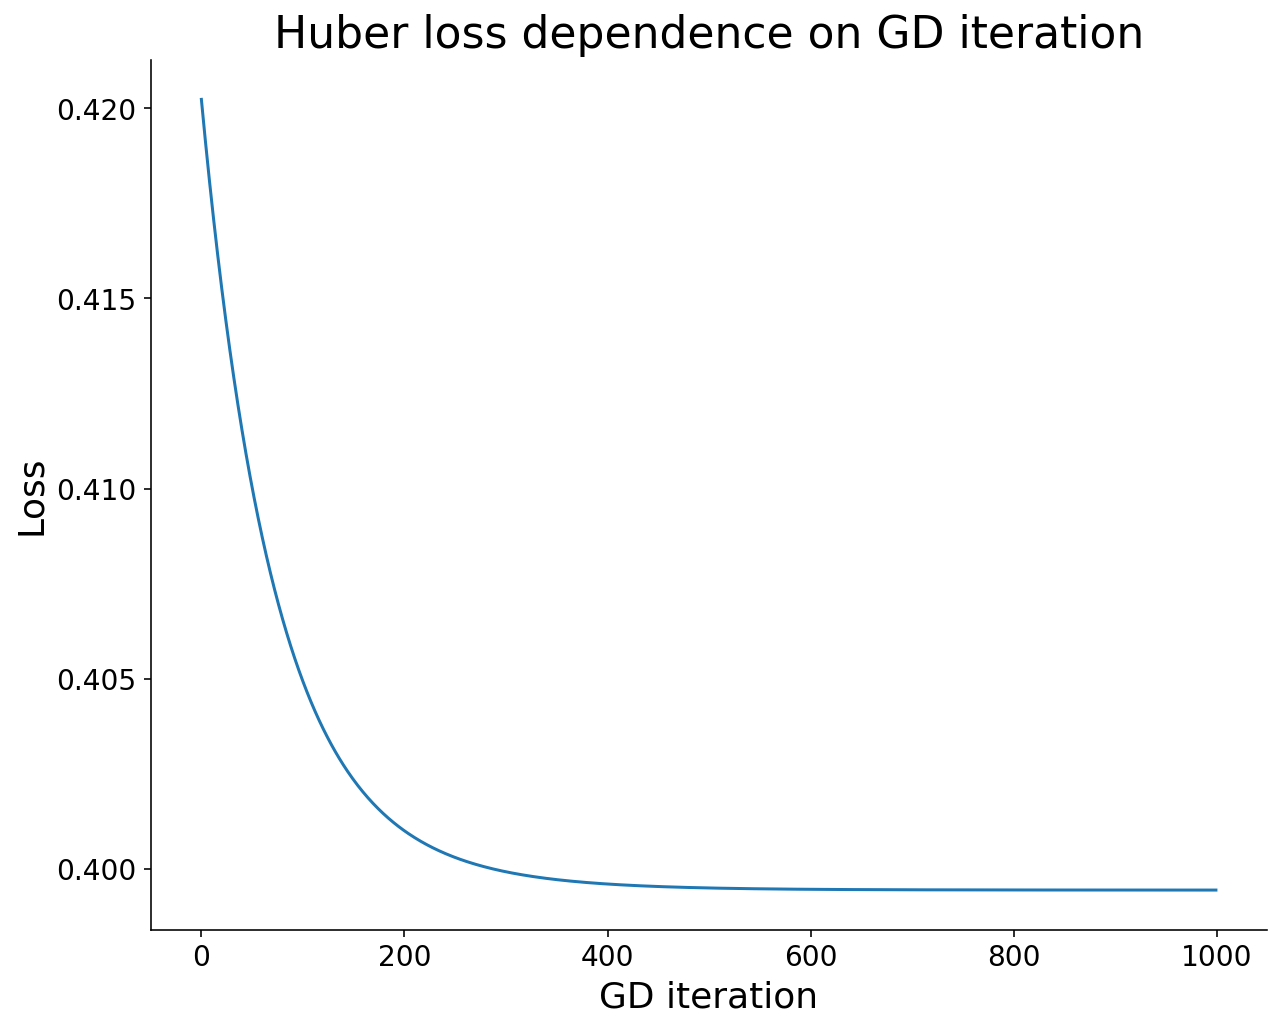

In [38]:
fig = plt.figure(figsize=(10, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot([i[0] for i in enumerate(loss_history)], loss_history)
plt.title('Huber loss dependence on GD iteration', fontsize=22)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('GD iteration', fontsize=18)

# Практика (8 + 0.5*)

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

# Мое добавление
from math import sqrt

%config InlineBackend.figure_format ='retina'
%matplotlib inline

В этой части вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача — предсказание цены дома.

In [40]:
data = pd.read_csv('train.csv', header=0)

In [41]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [42]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [43]:
data.drop('Id', axis=1, inplace=True)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

1.

Да, в данных есть пропуски.

In [44]:
data.isnull().any().any()

True

2.

Посмотрим, в каких именно признаках есть пропуски.

In [45]:
columns_na = []

for idx, na in enumerate(data.isnull().any()):
    if na:
        columns_na.append(data.columns[idx])

columns_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Посчитаем их количество и долю от общего количества значений.

In [46]:
for idx, na in enumerate(columns_na):
    print(na)
    print('Total number of missing values:', data[columns_na[idx]].isnull().value_counts()[True])
    a, b = data[columns_na[idx]].isnull().value_counts()[True], data[columns_na[idx]].isnull().value_counts()[False]
    print('Fraction of missing values from the total.: ' + str(round(a / (a + b), 3) * 100) + '%')
    print('')

LotFrontage
Total number of missing values: 259
Fraction of missing values from the total.: 17.7%

Alley
Total number of missing values: 1369
Fraction of missing values from the total.: 93.8%

MasVnrType
Total number of missing values: 8
Fraction of missing values from the total.: 0.5%

MasVnrArea
Total number of missing values: 8
Fraction of missing values from the total.: 0.5%

BsmtQual
Total number of missing values: 37
Fraction of missing values from the total.: 2.5%

BsmtCond
Total number of missing values: 37
Fraction of missing values from the total.: 2.5%

BsmtExposure
Total number of missing values: 38
Fraction of missing values from the total.: 2.6%

BsmtFinType1
Total number of missing values: 37
Fraction of missing values from the total.: 2.5%

BsmtFinType2
Total number of missing values: 38
Fraction of missing values from the total.: 2.6%

Electrical
Total number of missing values: 1
Fraction of missing values from the total.: 0.1%

FireplaceQu
Total number of missing valu

Визуализируем пропуски.

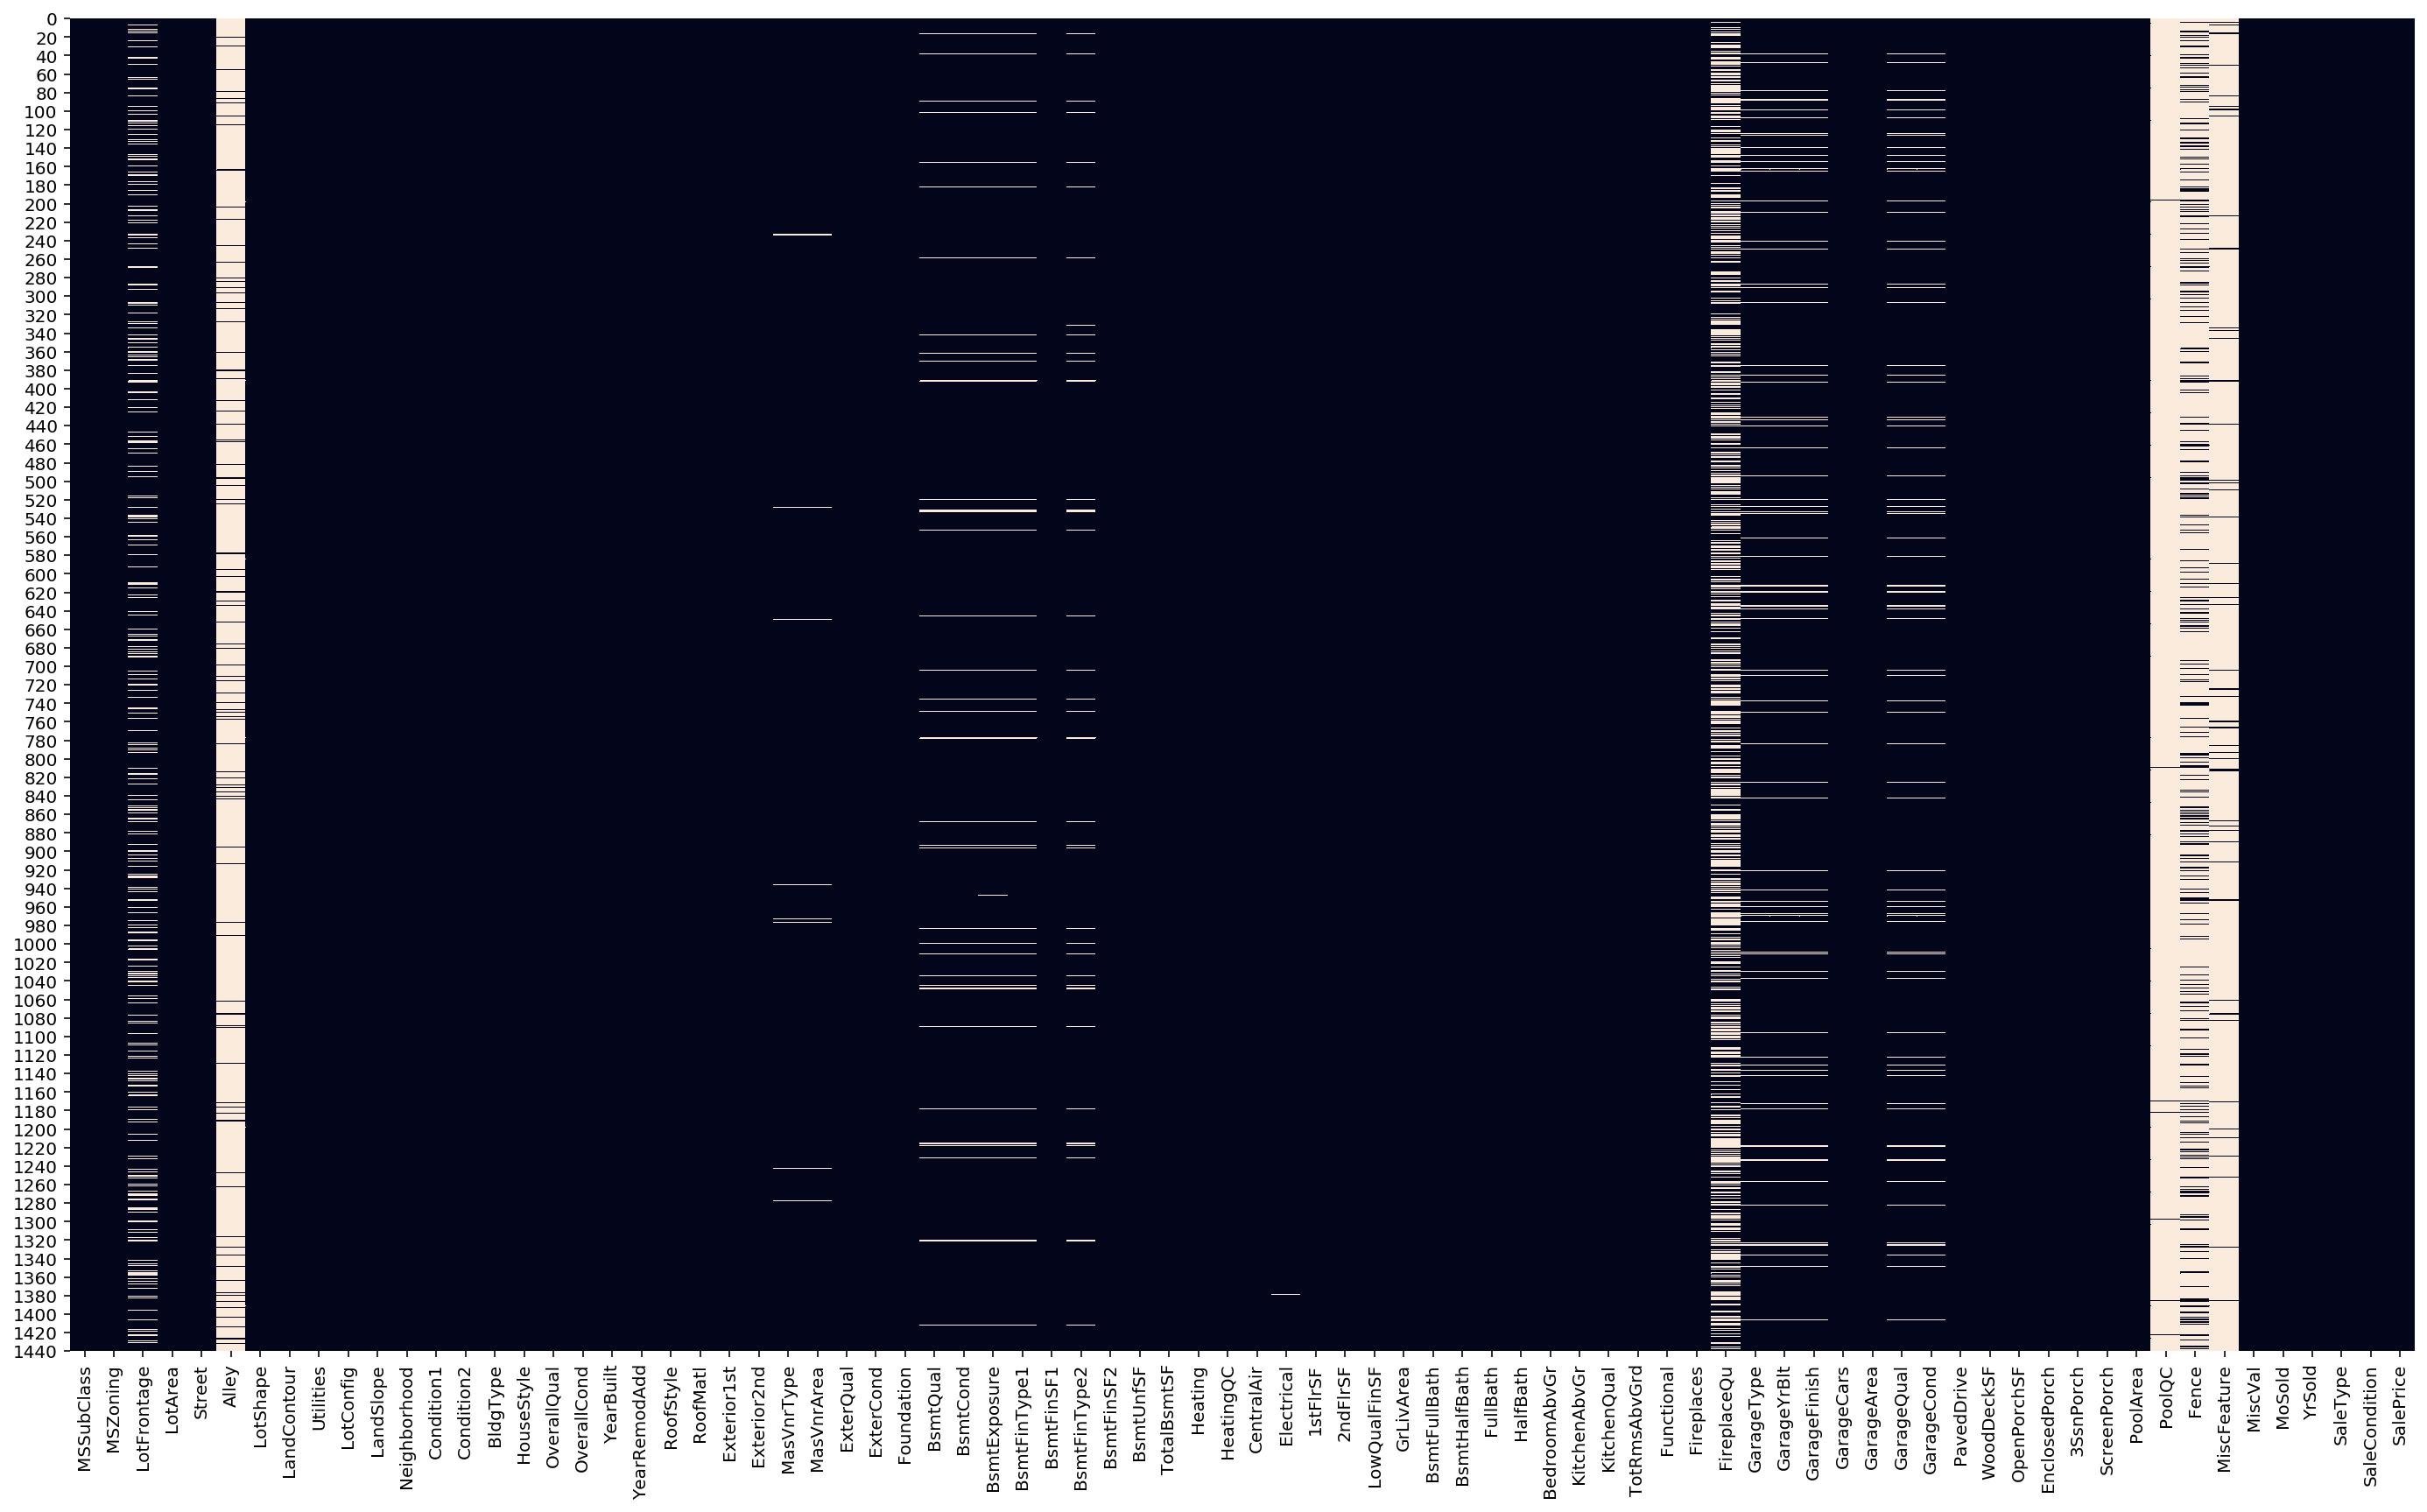

In [47]:
plt.figure(figsize=(24, 14))
sns.heatmap(data.isnull(), cbar=False)

3.

Можно заметить, что у некоторых групп признаков одинаковое количество пропусков. К примеру, возьмем признаки `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond`. Пропуски здесь означают, что в доме нет гаража.

In [48]:
data[columns_na[-8:-3]][data['GarageType'].isnull() == True]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1349,NaN,NaN,NaN,NaN,NaN
1407,NaN,NaN,NaN,NaN,NaN
1449,NaN,NaN,NaN,NaN,NaN
1450,NaN,NaN,NaN,NaN,NaN


Тоже самое касается и `Alley`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `FireplaceQu`, `PoolQC`, `Fence`, `MiscFeature`. Условно назовем эти признаки __"первой группой"__. Заметим, что они все, кроме `GarageYrBlt` (год возведения гаража), категориальные.

Однако у признаков `LotFrontage`, `MasVnrType`, `MasVnrArea`, `Electrical` действительно пропущенны значения. Условно назовем их __"второй группой"__. Заметим, что `MasVnrType` и `Electrical` — категориальные признаки (это важно обозначить для следующего пункта).

## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

### Первая группа признаков: 

a) Для категориальных признаков — где пропуски означают, что в доме отсутсвует какой-то предмет (гараж, бассейн, подвал, забор и т.д.), — дополним множество значений новой категорией `None`. 

Выберем все категориальные признаки и исключим `MasVnrType` и `Electrical`, так как они относятся ко __второй группе__.

In [49]:
data[columns_na].select_dtypes(include='object').columns

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [50]:
columns_not_wanted = data[columns_na].select_dtypes(include='object').columns.isin(['MasVnrType', 'Electrical'])
columns_not_wanted

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False])

In [51]:
columns_wanted = data[columns_na].select_dtypes(include='object').columns[~columns_not_wanted]

In [52]:
data[columns_wanted] = data[columns_wanted].fillna('None')

__NB__: Заметим из вышепостроенной heatmap, что у признаков `Alley`, `PoolQC`, `Fence`, `MiscFeature` пропуски составляют более 50% от общего числа значений.  У нас слишком мало данных, чтобы судить что они как-то влияют на целевую переменную, так что удалим их.

In [53]:
data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

б) Вещественные признаки

Признак`GarageYrBlt` удалим, так как у в некоторых домах нет гаража.

In [54]:
data.drop(['GarageYrBlt'], axis=1, inplace=True)

### Вторая группа признаков:

а) Пропуски в категориальных признаках (`MasVnrType` и `Electrical`) заполним наиболее встречающемся значением, то есть модой.

In [55]:
data['MasVnrType'] = data['MasVnrType'].fillna(data['MasVnrType'].mode()[0])

In [56]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

б) Пропуски в вещественных признаках (`LotFrontage`, `MasVnrArea`) заполним средним значением.

In [57]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())

In [58]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(data['MasVnrArea'].mean())

### Проверка:

In [59]:
data.isnull().any().any()

False

## 3 (1) 

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

Метод label кодирования заключается в том, что катигориальный признак $f_j(x)$ из множества $C = \{c_1, ..., c_m\}$ заменяется на признак $g_j(x)$, состоящий из чисел $\{0, ..., m-1\}$. 

Проблема такого подхода: модель будет считать, что данные имеют некоторый порядок $0 < 1 < ... < m-1$, что верно для порядкового признака, а не категориального.

Чтобы не допустить этого, воспользуемся one-hot кодированием. Также уберем по одному столбцу множества категориального, дабы бинаризированные признаки не были линейно зависимы между собой.

In [60]:
data2 = pd.get_dummies(data, drop_first=True)

In [61]:
data2.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

Корреляцию Пирсона для категориальных признаков (и бинарных) признаков считать не особо осмысленно — https://www.quora.com/Can-I-use-Pearsons-correlation-with-categorical-variables, — так что посчитаем ее для всех остальных.

In [62]:
data_feat = data[data.columns[:-1]] # исключаем целевую переменную

In [63]:
cat_feat_mask = (data_feat.dtypes == "object").values

In [64]:
data_feat_real = data_feat[data_feat.columns[~cat_feat_mask]]

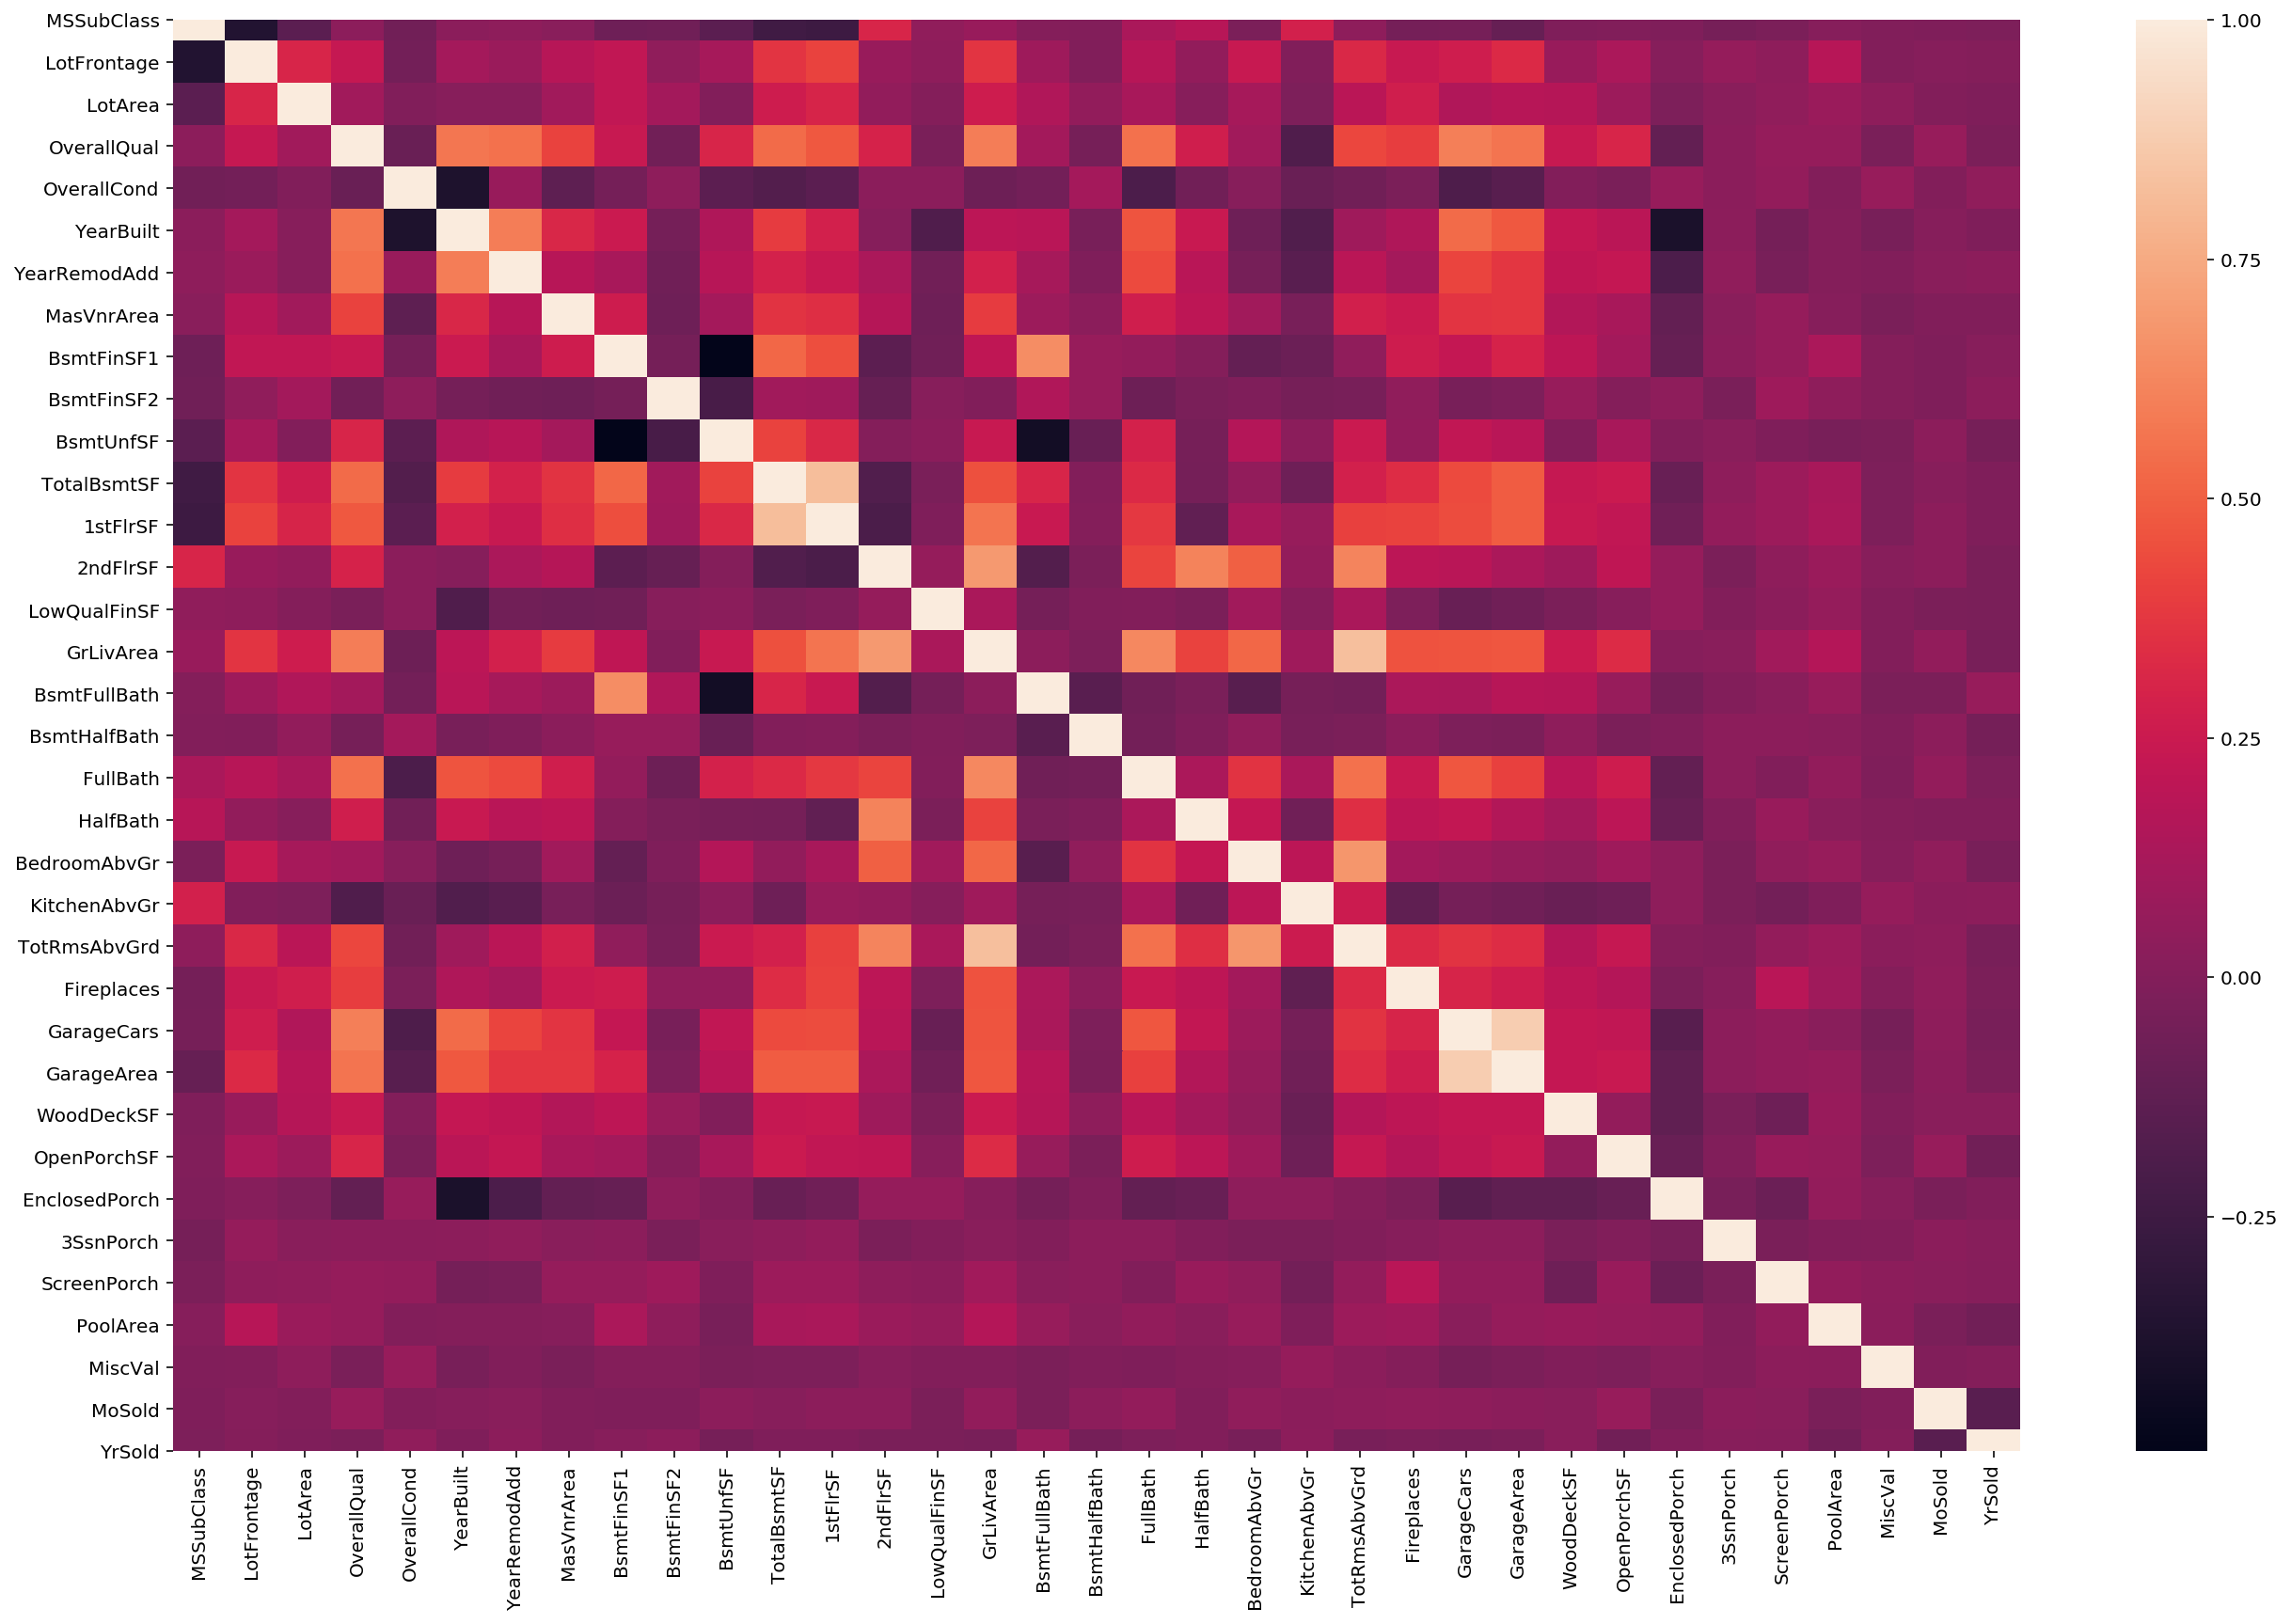

In [65]:
plt.figure(figsize=(22, 14))
corr = data_feat_real.corr()
sns.heatmap(corr)

Вывод: так как для некоторых признаков $X$ и $Y$ $Corr(X,Y) \neq 0$ и, следовательно, $Cov(X,Y) \neq 0$, то X и Y линейно зависимы, что означает — это мы увидем дальше, — переобучение линейной регрессии.

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [66]:
max_corr_features = []
max_corr = 0
min_corr_features = []
min_corr = 1

for col in data_feat_real.columns:
    corr = abs(round(np.corrcoef(data[col], data['SalePrice'])[0, 1], 2))
    if corr > max_corr:
        max_corr = corr
        max_corr_features = [(col, corr)]
    elif corr == max_corr:
        max_corr_features.append((col, corr))
    
    if corr < min_corr:
        min_corr = corr
        min_corr_features = [(col, corr)]
    elif corr == max_corr:
        min_corr_features.append((col, corr))
        
print('Maximum correlation with target value:', *max_corr_features)
print('Minimum correlation with target value:', *min_corr_features)


Maximum correlation with target value: ('OverallQual', 0.79)
Minimum correlation with target value: ('BsmtFinSF2', 0.01)


Изобразим зависимость.

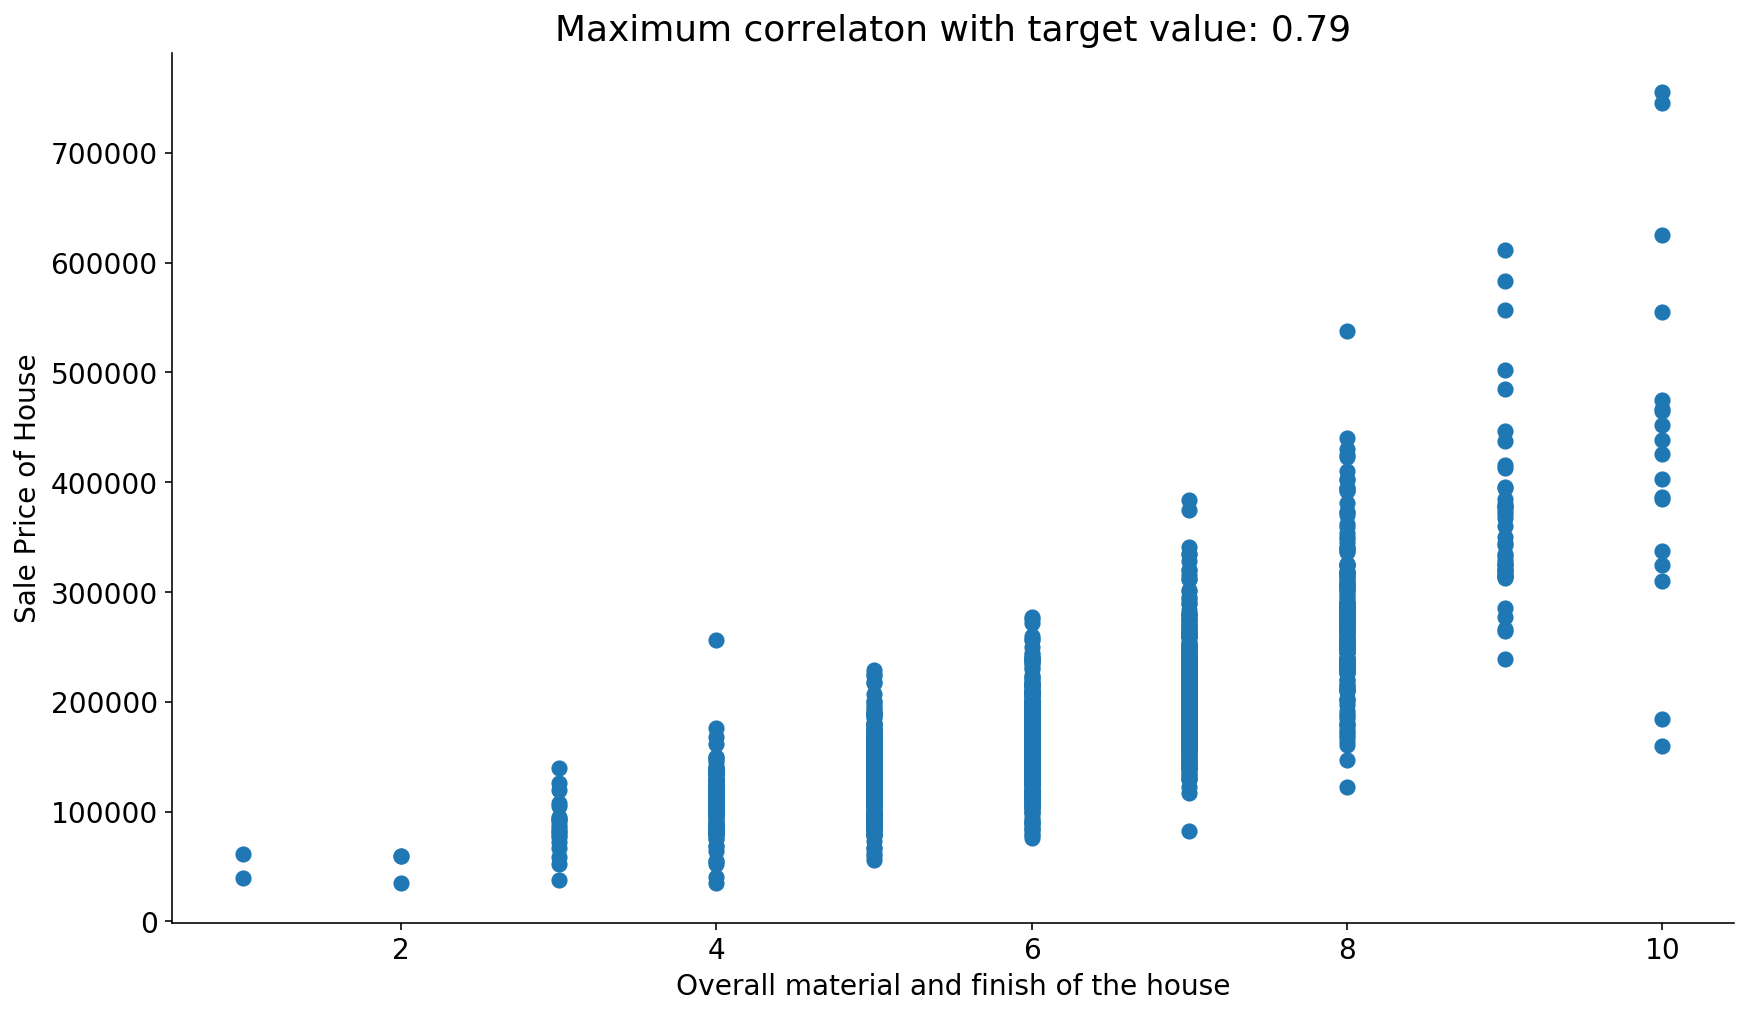

In [67]:
plt.figure(figsize=(14, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title("Maximum correlaton with target value: {}".format(max_corr_features[0][1]), fontsize=18)
plt.xlabel("Overall material and finish of the house", fontsize=14)  
plt.ylabel("Sale Price of House", fontsize=14)

plt.scatter(data['OverallQual'], data['SalePrice'], s=50)

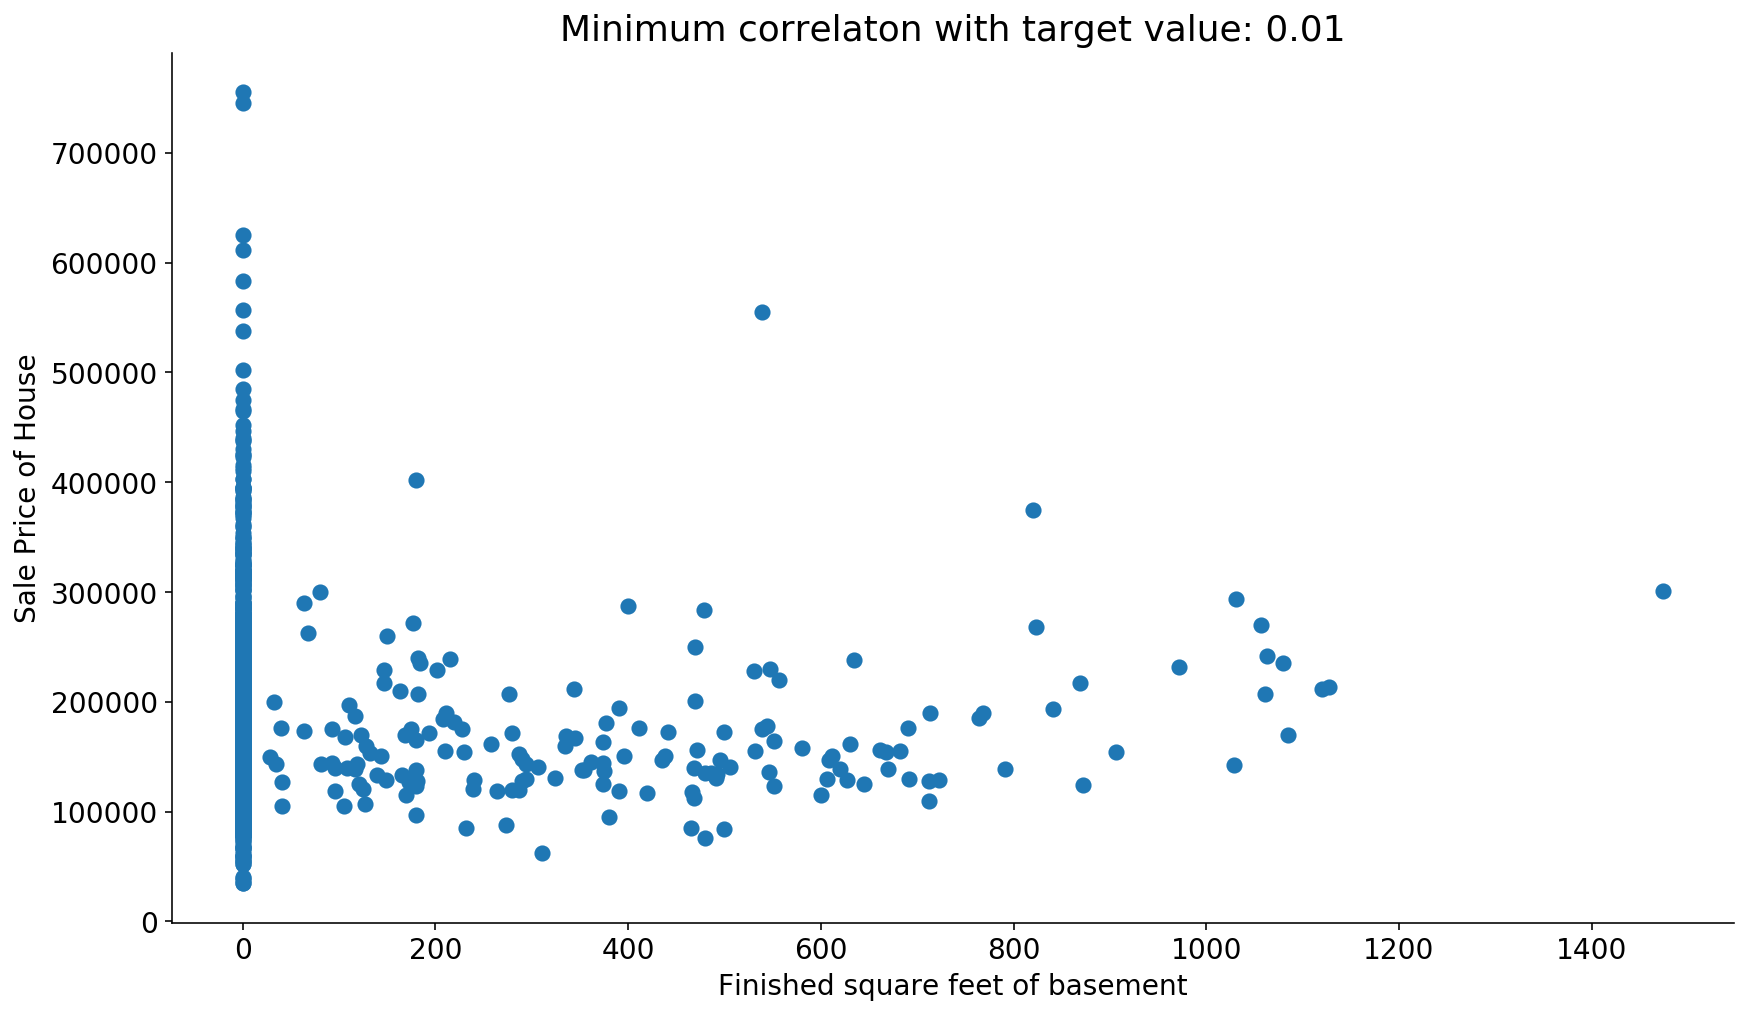

In [68]:
plt.figure(figsize=(14, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title("Minimum correlaton with target value: {}".format(min_corr_features[0][1]), fontsize=18)
plt.xlabel("Finished square feet of basement", fontsize=14)  
plt.ylabel("Sale Price of House", fontsize=14)

plt.scatter(data['BsmtFinSF2'], data['SalePrice'], s=50)

Площадь подвала почти никак не влияет на стоимость дома. Тогда его и почти все признаки с подвалом, кроме TotalBsmtSF и BsmtQual (они нормально коррелируют с целевой переменной),  можно удалить.

In [69]:
data.drop(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'], 
          axis=1, inplace=True)

Заново применим one-hot кодирование.

In [70]:
data2 = pd.get_dummies(data, drop_first=True)

In [71]:
data2.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,856,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,1262,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,920,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,756,961,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,1145,1145,...,0,0,0,0,1,0,0,0,1,0


## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также "смещения" распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

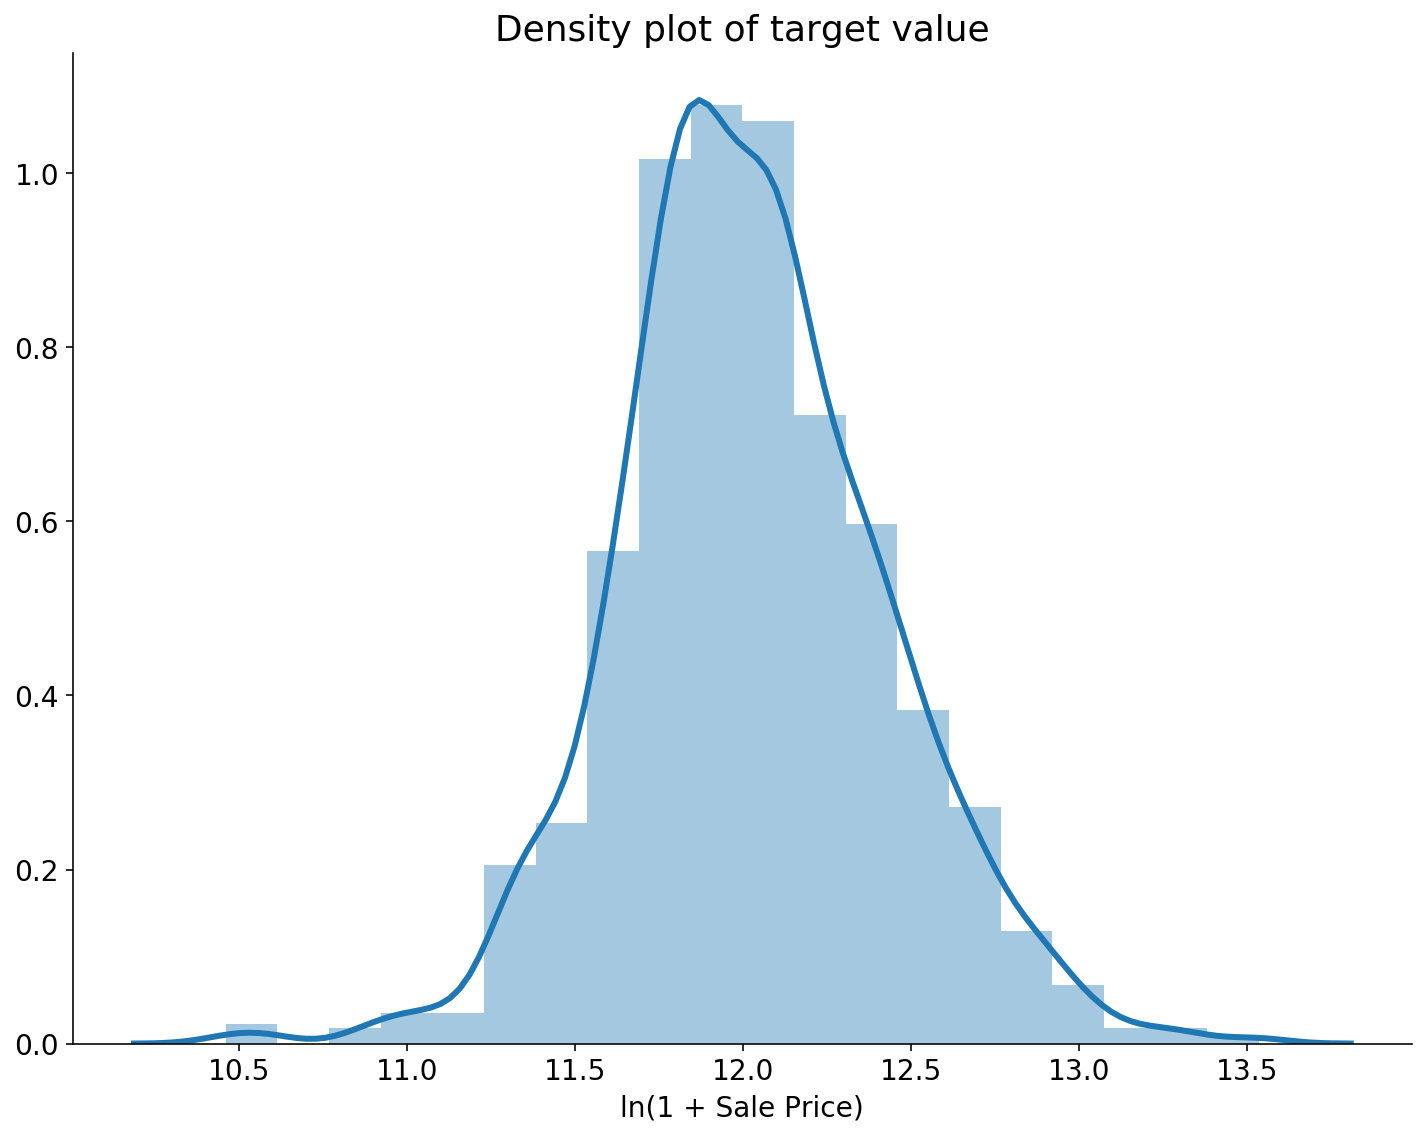

In [72]:
lny_1 =  np.log1p(data['SalePrice'])

plt.figure(figsize=(10, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title("Density plot of target value", fontsize=18)
plt.xlabel("ln(1 + Sale Price)", fontsize=14)

sns.distplot(lny_1, bins=20, hist=True, kde=True,
             kde_kws = {'shade': False, 'linewidth': 3}, axlabel=False)

plt.tight_layout()

Действительно, распределение целевой переменной похоже на нормальное.

Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    data2.drop('SalePrice', axis=1),
    np.log1p(data['SalePrice']),
    random_state=13
)

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1095, 222), (365, 222), (1095,), (365,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- Линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

### 1. Масштабирование данных

Перед тем, как начать применять различные алгоритмы, приведем все признаки к одной шкале измерения. Применим `StandardScaler`.

In [75]:
scaler = StandardScaler()

Здесь мы не будем масштабировать бинаризированные категориальные признаки.

Для этого возьмем вещественные признаки до кодирования категориальных признаков

In [76]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
      

In [77]:
no_cat = data.dtypes != 'object'
no_cat_columns = data[data.columns[no_cat]].columns[:-1] # [:-1] — исключаем целевую переменную

In [78]:
X_train_standartized = X_train.copy()

for col in no_cat_columns:
    X_train_standartized[col] = scaler.fit_transform(X_train_standartized[[col]])

In [79]:
X_train_standartized.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
998,-0.633258,-0.480974,-0.071699,-2.267430,-1.428699,-1.640697,-1.694812,-0.588988,-0.094763,-0.197675,...,0,0,0,0,1,0,0,0,1,0
883,0.432081,-0.480974,-0.424859,-1.531339,-0.524929,-1.974786,-1.694812,-0.588988,-0.602933,-0.526283,...,0,0,0,0,1,0,0,0,1,0
792,0.076968,1.127170,-0.058488,0.676935,-0.524929,0.831561,0.593618,-0.588988,0.168911,-0.064094,...,0,0,0,0,1,0,0,0,1,0
617,-0.278145,-0.531229,-0.323998,-0.059156,0.378841,-0.571613,-1.500052,-0.588988,-0.514243,-0.852220,...,0,0,0,0,1,0,0,0,1,0
1028,-0.159774,0.473861,-0.100685,-0.795247,-0.524929,-1.005928,-1.694812,-0.588988,-0.667652,-0.488881,...,0,0,0,0,1,0,0,0,1,0


In [80]:
X_test_standartized = X_test.copy()

for col in no_cat_columns:
    X_test_standartized[col] = scaler.fit_transform(X_test_standartized[[col]])

In [81]:
X_test_standartized.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
662,-0.880289,1.773472,0.320342,-0.107651,-2.264723,-0.120897,-0.813861,0.623074,0.608936,0.464263,...,0,0,0,0,1,0,0,0,1,0
1187,-0.880289,0.640204,0.204242,1.271043,-0.494650,0.719010,0.475832,-0.533301,1.076910,1.018134,...,0,0,0,0,1,0,0,0,1,0
1305,-0.880289,1.334787,0.279459,1.960390,-0.494650,1.106659,1.049029,1.072775,1.133389,1.084981,...,0,0,0,0,1,0,0,0,1,0
945,-0.173087,0.969217,-0.180397,-0.796999,0.390386,-2.640618,0.523598,-0.533301,-0.004272,-0.022762,...,0,0,0,0,1,0,0,0,1,0
269,-0.880289,-0.052553,-0.275791,-0.107651,1.275422,0.137536,-0.431730,0.398223,0.106670,-0.201815,...,0,0,0,0,1,0,0,0,1,0


Теперь вернемся к алгоритмам.

### 2. kNN

In [82]:
knn = KNeighborsRegressor()
knn.fit(X_train_standartized, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [83]:
y_pred = knn.predict(X_test_standartized)

In [84]:
sqrt(mean_squared_error(y_test, y_pred))

0.20329925697528053

Кросс-валидация

In [85]:
grid_searcher = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'n_neighbors': range(1, 40, 2), # обычно для knn берутся нечетные значения
        'weights': ['uniform', 'distance'], # сравниваем разные веса
        'p': [1, 2, 3] # сравниваем разные метрики
    },
    cv=5
)

In [86]:
grid_searcher.fit(X_train_standartized, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 40, 2), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Лучшие гиперпараметры:

In [87]:
grid_searcher.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [88]:
best_predictions = grid_searcher.predict(X_test_standartized)

In [89]:
print('RMSE:', sqrt(mean_squared_error(y_test, best_predictions)))

RMSE: 0.19509642261085572


### 3. Линейная регрессия

In [90]:
lr = LinearRegression()
lr.fit(X_train_standartized, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
y_pred = lr.predict(X_train_standartized)

In [92]:
print('RMSE on train data:', sqrt(mean_squared_error(y_train, y_pred)))

RMSE on train data: 0.09712874148074677


In [93]:
y_pred = lr.predict(X_test_standartized)

In [94]:
print('RMSE on test data:', sqrt(mean_squared_error(y_test, y_pred)))

RMSE on test data: 129657557052.80472


Как видим, модель переобучена. Очевидно, что такой же результат мы получем и для выборки, масштабированной по `StandardScaler` Попробуем исправить посредством L1- или L2-регуляризатора (пункты 4 и 5, соответственно).

Сохраним веса, так как они нам понадобятся в следующем задании:

In [95]:
lr_w = lr.coef_

### 4. Lasso (L1-регуляризатор)

In [96]:
lasso_regressor = Lasso()

In [97]:
lasso_regressor.fit(X_train_standartized, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [98]:
y_pred = lasso_regressor.predict(X_test_standartized)

In [99]:
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 0.40693313326369857


Воспользуемся кросс-валидацией

In [100]:
grid_searcher = GridSearchCV(
    Lasso(),
    param_grid={
        'alpha': [1e-15, 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20],
        'tol': [1e-6, 1e-4, 1e-3],
        'max_iter': [1000, 10000]
    },
    cv=5
)

In [101]:
grid_searcher.fit(X_train_standartized, y_train)

/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2420469621993826, tolerance: 0.0001402794191111797
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2346034137971027, tolerance: 0.00014015897814864155
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9075829932186865, tolerance: 0.00013829800883236268
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: O

/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7665088116945546, tolerance: 0.1323167507983513
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2416302071109175, tolerance: 0.0001402794191111797
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.230147030006869, tolerance: 0.00014015897814864155
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8456520860545766, tolerance: 0.1384998620523727
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7664932609849693, tolerance: 0.1323167507983513
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2001715583076913, tolerance: 0.0001402794191111797
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7665474142874515, tolerance: 0.1323167507983513
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0230221599077889, tolerance: 0.0001402794191111797
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14009141077314968, tolerance: 0.00014015897814864155
  positive)
/Users/khaykingleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Obje

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-06, 0.0001, 0.001,
                                   0.01, 0.1, 1, 2, 3, 4, 5, 10, 20],
                         'max_iter': [1000, 10000],
                         'tol': [1e-06, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Лучшие гиперпараметры:

In [102]:
grid_searcher.best_params_

{'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}

In [103]:
best_predictions = grid_searcher.predict(X_test_standartized)

Качество алгоритма на контрольной выборке:

In [104]:
print('RMSE using test data:', sqrt(mean_squared_error(y_test, best_predictions)))

RMSE using test data: 0.20272627888199451


Сохраним веса для следующего задания:

In [105]:
lasso_regressor = Lasso(alpha=0.001, max_iter=1000, tol=1e-06)

In [106]:
lasso_regressor.fit(X_train_standartized, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=1e-06, warm_start=False)

In [107]:
lr_lasso_w = lasso_regressor.coef_

Можно заметить, что L1-регулятризатор занулил часть весов:

In [108]:
lr_lasso_w

array([-6.94782790e-03,  1.41682225e-02,  1.81152479e-02,  7.54973390e-02,
        5.25859411e-02,  7.11353648e-02,  1.58460257e-02,  4.38009634e-03,
        5.10268969e-02,  4.57642466e-03,  0.00000000e+00, -9.46577884e-03,
        1.40770390e-01,  3.51059941e-02,  3.81672290e-03,  9.29820351e-03,
        2.73421986e-03, -8.02210433e-03, -7.39095871e-03,  0.00000000e+00,
        1.38699912e-02,  2.38075025e-02,  1.78118274e-02,  1.52586244e-02,
        3.75571334e-03,  7.58929327e-03,  3.65769569e-03,  1.18906850e-02,
        2.00552761e-03, -5.18637639e-03,  0.00000000e+00, -6.39651853e-03,
        3.79525977e-02,  0.00000000e+00,  5.91193287e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.26528523e-02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.09398998e-02,  

### 5. Ridge (L2-регуляризатор)

In [109]:
ridge_regressor = Ridge()

In [110]:
ridge_regressor.fit(X_train_standartized, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [111]:
y_pred = ridge_regressor.predict(X_test_standartized)

In [112]:
print('RMSE using test data:', sqrt(mean_squared_error(y_test, y_pred)))

RMSE using test data: 0.19918667309205254


Воспользуемся кросс-валидацией.

In [113]:
grid_searcher = GridSearchCV(
    Ridge(),
    param_grid={
        'alpha': [1e-15, 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20],
        'tol': [1e-6, 1e-4, 1e-3],
        'max_iter': [1000, 10000]
    },
    cv=5
)

In [114]:
grid_searcher.fit(X_train_standartized, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-06, 0.0001, 0.001,
                                   0.01, 0.1, 1, 2, 3, 4, 5, 10, 20],
                         'max_iter': [1000, 10000],
                         'tol': [1e-06, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Лучшие гиперпараметры:

In [115]:
grid_searcher.best_params_

{'alpha': 10, 'max_iter': 1000, 'tol': 1e-06}

In [116]:
best_predictions = grid_searcher.predict(X_test_standartized)

Качество алгоритма на контрольной выборке:

In [117]:
print('RMSE using test data:', sqrt(mean_squared_error(y_test, best_predictions)))

RMSE using test data: 0.20073939456818804


Сохраним веса для следующего задания:

In [121]:
ridge_regressor = Ridge(alpha=10, max_iter=1000, tol=1e-06)

In [122]:
ridge_regressor.fit(X_train_standartized, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      random_state=None, solver='auto', tol=1e-06)

In [123]:
lr_ridge_w = ridge_regressor.coef_

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

Наша линейная регрессия без регуляризации переобучена: это можно заметить по большим весам (при небольшом изменении значения признака прогноз по целевой переменной очень сильно меняется). 

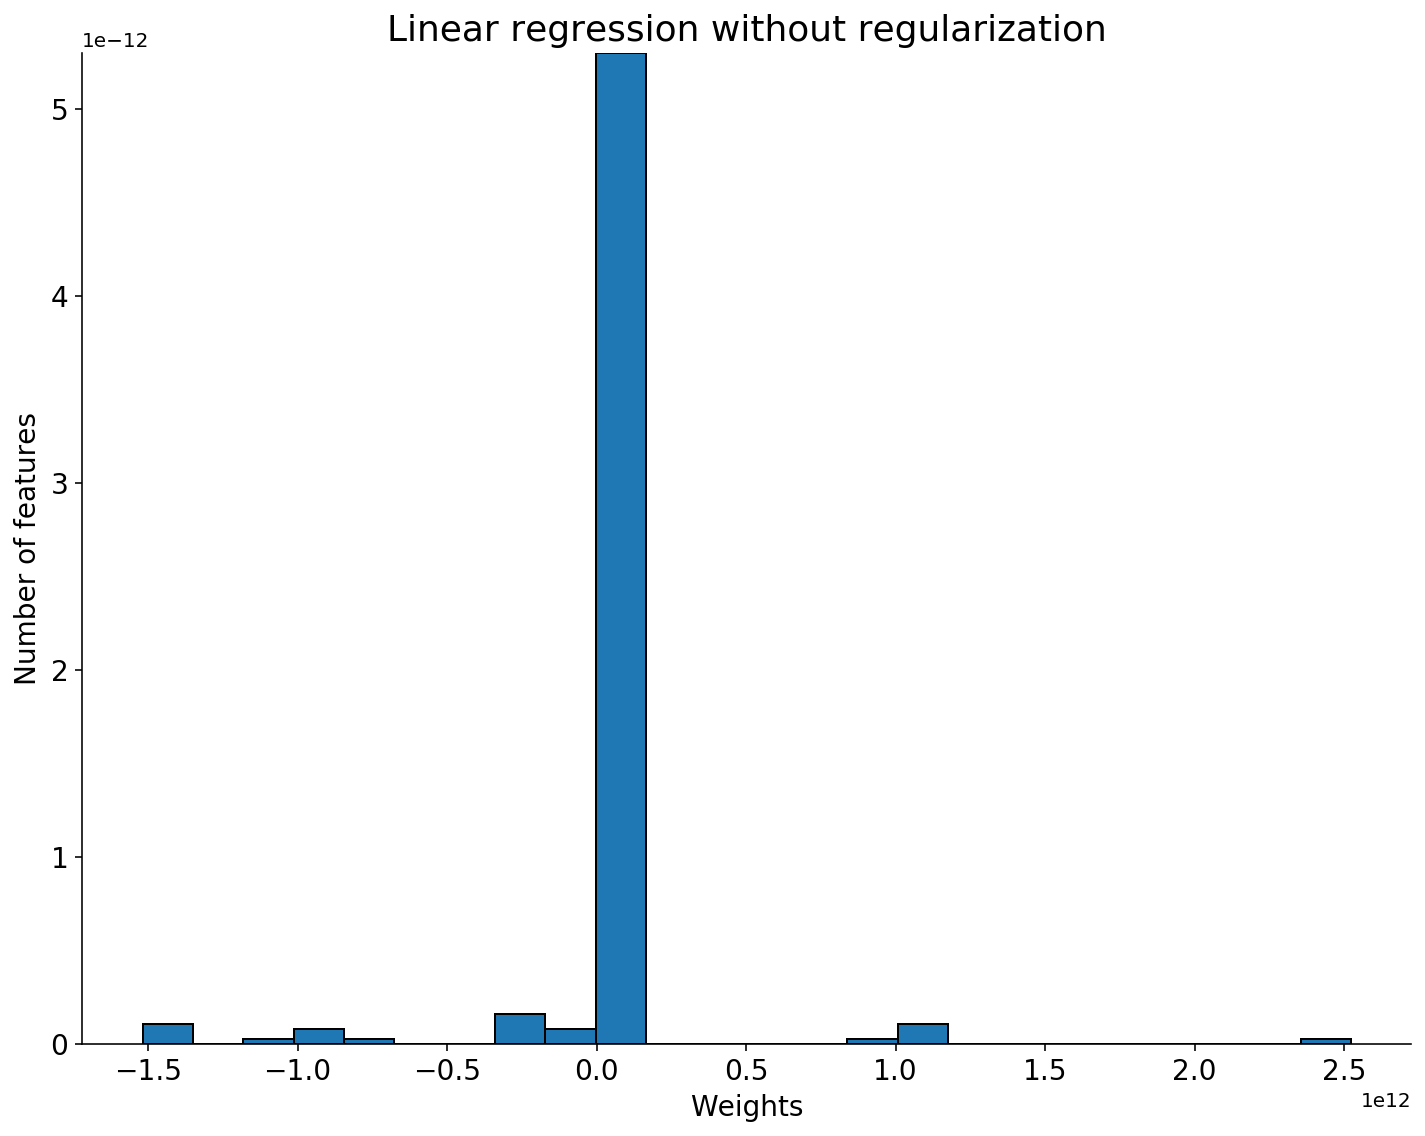

In [124]:
plt.figure(figsize=(10, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(lr_w, bins=24, density=True, ec='black')
plt.title("Linear regression without regularization", fontsize=18)
plt.xlabel("Weights", fontsize=14)  
plt.ylabel("Number of features", fontsize=14)

plt.tight_layout()

Почему так? Наши данные неидеальные и, как мы увидели в задании 4, некоторые признаки слабо или сильно коррелируемы друг с другом.

Если $Corr(X,Y) \neq 0$, то и $Cov(X,Y) \neq 0$, — это значит, что признаки $X$ и $Y$ линейно зависимы.

Если в выборке $X$ есть ЛЗ признаки, то существует такой вектор $v \neq 0$, что $<v,x>=0 \ \ \forall x$.

Пусть мы нашли оптимальные значения весов $w^*$. Тогда классификаторы $w^* + \alpha v$ будут выдавать точно такие же ответы на всех отбъектах, потому что

$<w^* + \alpha v, x> \ = \ <w^*, x> + \ \alpha <v,x> \  = \ <w^*, x> $.

Это означает, что метод оптимизации может найти решение со сколько угодно большими весами, и, как мы знаем, это верный признак переобучения модели.

Для того, чтобы решить эту проблему мы добавляем к функционалу ошибки регуляризатор, который штрафует модель за слишком большую норму весов.

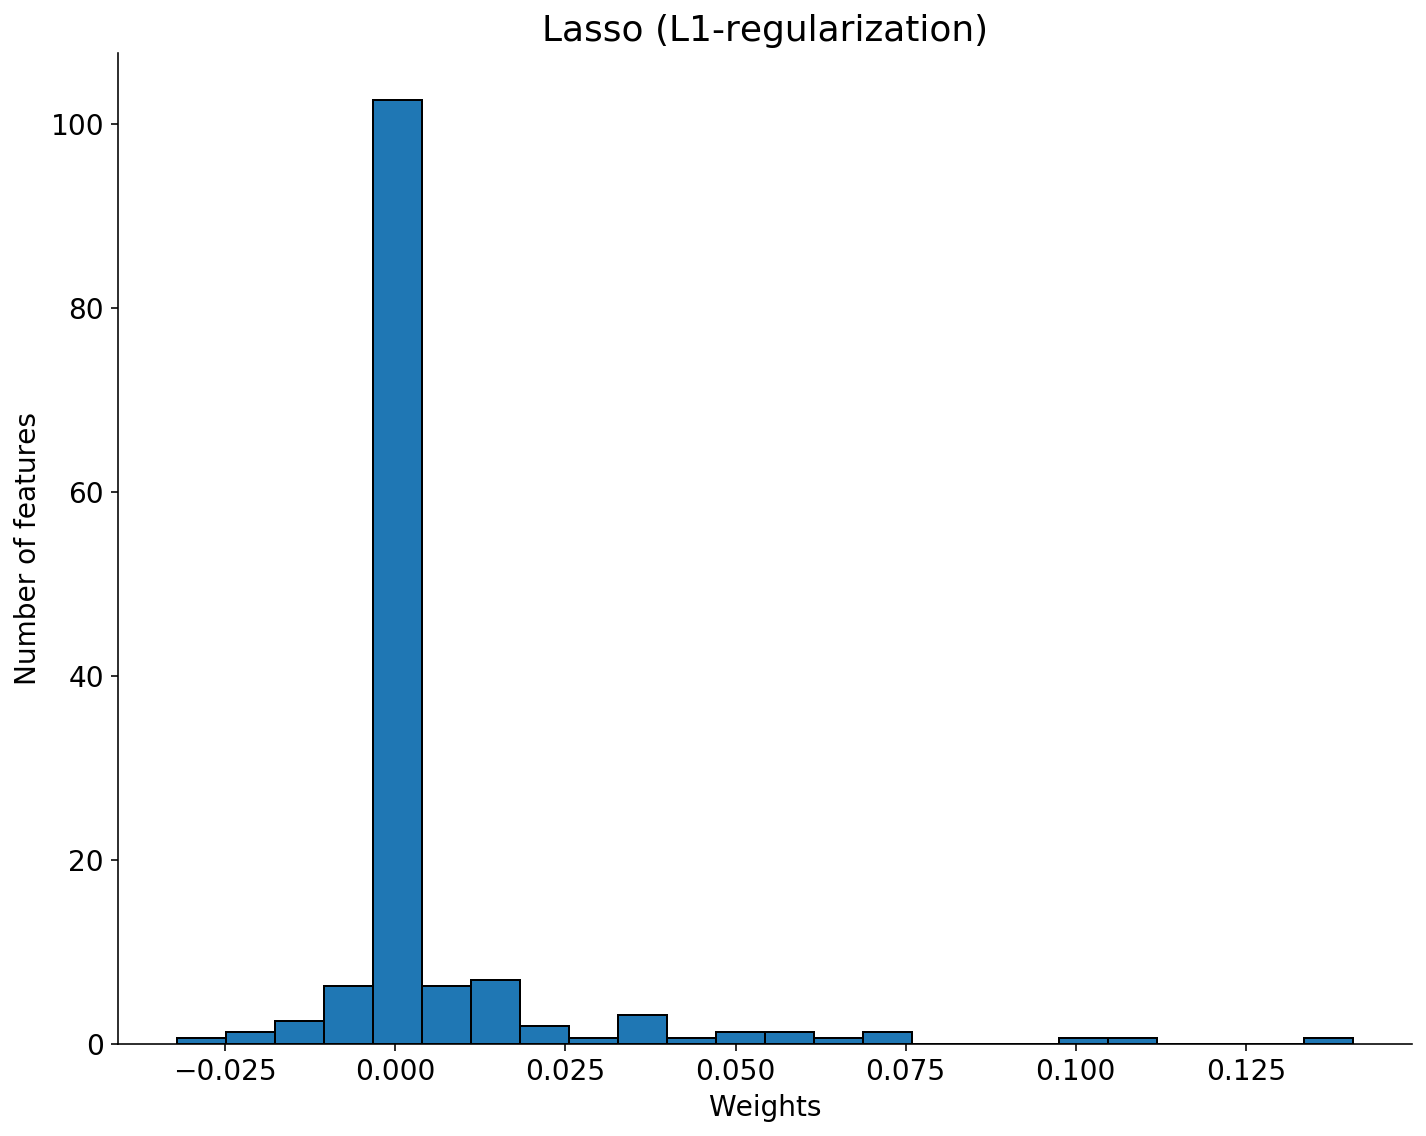

In [125]:
plt.figure(figsize=(10, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(lr_lasso_w, bins=24, density=True, ec='black')
plt.title("Lasso (L1-regularization)", fontsize=18)
plt.xlabel("Weights", fontsize=14)  
plt.ylabel("Number of features", fontsize=14)

plt.tight_layout()

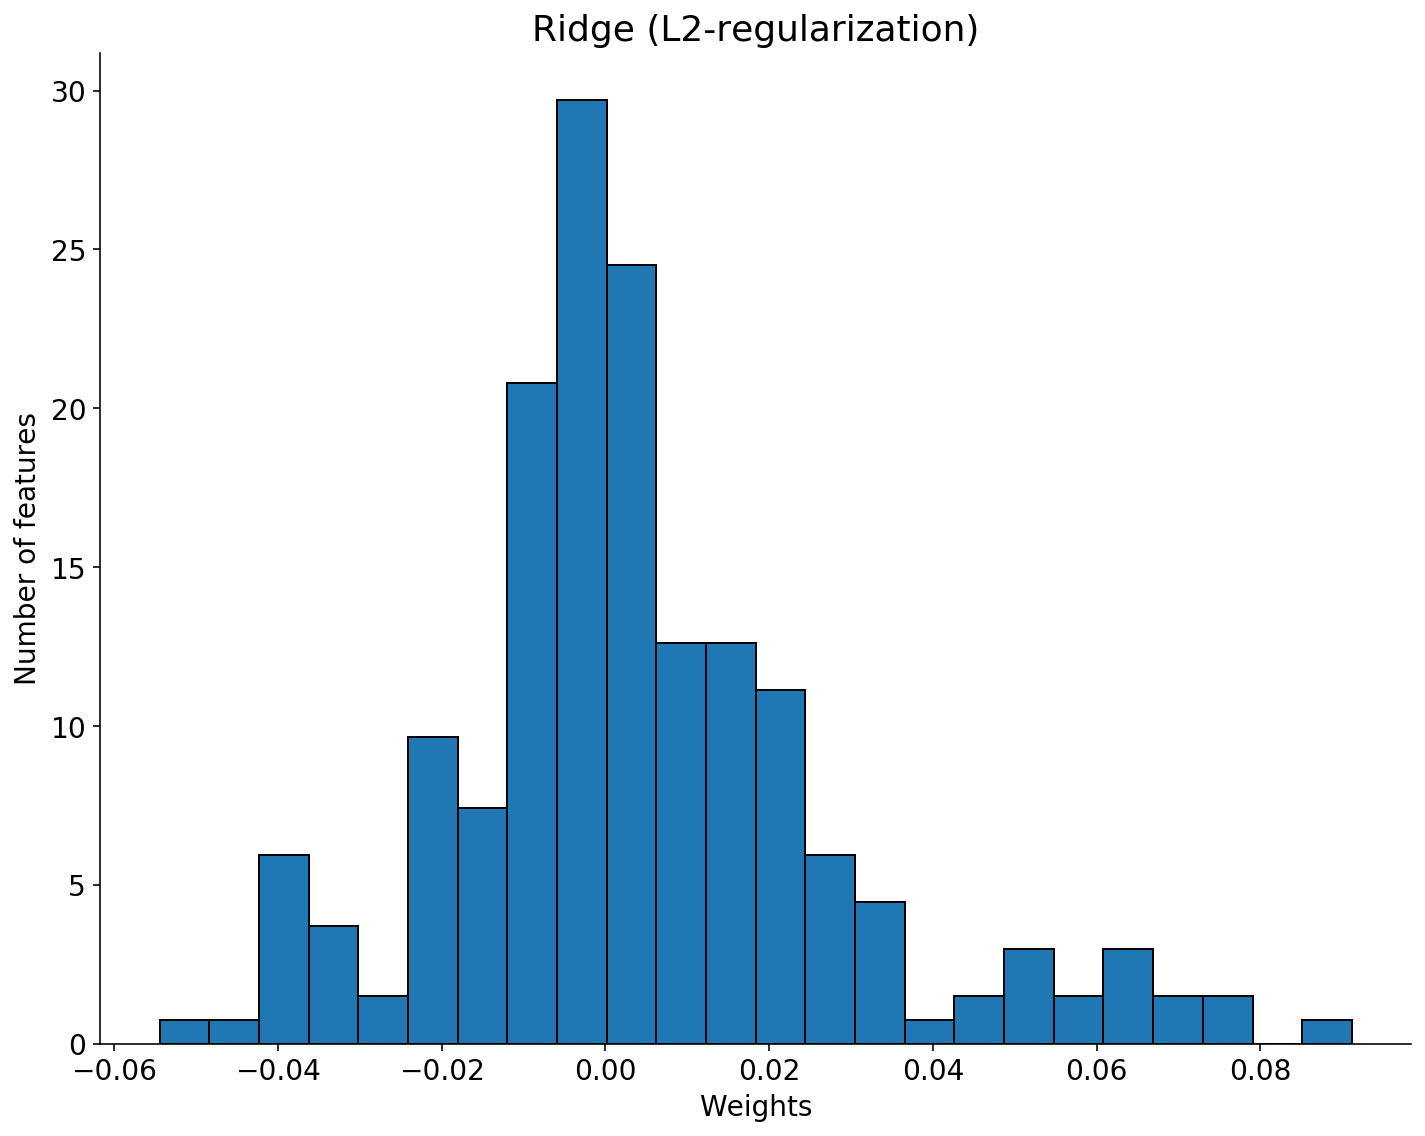

In [126]:
plt.figure(figsize=(10, 8))

# Удаляем лишние границы для красоты
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(lr_ridge_w, bins=24, density=True, ec='black')
plt.title("Ridge (L2-regularization)", fontsize=18)
plt.xlabel("Weights", fontsize=14)  
plt.ylabel("Number of features", fontsize=14)

plt.tight_layout()

Как можно заметить, L1- и L2-регуляризаторы различаются между собой: L1 зануляет большую часть весов, то по факту отбирает самые важные признаки.

Геометрическое объяснение:

L1 — имеет ограничение в виде ромба, а L2 — круга. Можноз аметить на графике справа, что при оптимизации функционала L1 зануляет один из признаков, в то время как L2 — нет.

<img src="https://miro.medium.com/max/600/1*GSQfWiZolZzSJfGTRaDnMg.png" height="1200" width="800"> 

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.212 на валидации по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

Решенно в 7.2, 7.4 и 7.5.

Также можно попробовать применить нелинейное преобразование признаков. Однако, так как мы уже добились требуемого качества, не будем этого делать :)

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.210 на валидации по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите — отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение — не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.

Решенно в 7.2, 7.4 и 7.5.

# Теория (1.5*)

За данную часть можно получить бонусные баллы. Решения необходимо оформить в этом же файле в ячейках типа Markdown, пользуясь $\LaTeX$ для записи математических формул.

## 1* (0.5)

Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

__Решение__:

Пусть $f_Y(y)$ — функция плотности распределения целевой переменной, тогда

$$
\text{Quantile loss}
=
\mathbb{E}[\rho_\tau\left(y_i - C\right)]
\to 
\min_C \limits.
$$

$$
\mathbb{E}[\rho_\tau\left(y_i - C\right)]
=
\int^{\infty}_{-\infty}\rho_\tau\left(y_i - C\right) f_Y(y) dy
= 
\int^{\infty}_{-\infty}(\tau [z > 0] + (1 + \tau) [z \leq 0])\left(y_i - C\right)f_Y(y) dy
=
$$
$$
\tau [z > 0]\int^{\infty}_{-\infty} \left(y_i - C\right)f_Y(y) dy
+ 
(1 + \tau) [z \leq 0]\int^{\infty}_{-\infty} \left(y_i - C\right)f_Y(y) dy
=
$$
$$
\tau \int^{\infty}_{C} \left(y_i - C\right)f_Y(y) dy 
+ 
(1 + \tau) \int^{C}_{-\infty} \left(y_i - C\right)f_Y(y) dy
\to 
\min_C \limits.
$$

$$
\dfrac{\partial}{\partial C}
\mathbb{E}[\rho_\tau\left(y_i - C\right)] 
=
- \tau \int^{\infty}_{C} f_Y(y)dy 
- (1 + \tau) \int^{C}_{-\infty} f_Y(y) dy
=
- \tau \mathbb{P}(Y > C) - (1 + \tau) \mathbb{P}(Y \leq C)
= \tau ( 1 - \mathbb{P}(Y \leq C)) - (1 + \tau) \mathbb{P}(Y \leq C)
= 
0
$$

Отсюда следует, что 

$$
\tau - \mathbb{P}(Y \leq C)
= 0.
$$

Тогда
$$
F_Y(C) = \mathbb{P}(Y \leq C) = \tau
$$

Значит, $C^*$ — это квантиль уровня $\tau$.

## 2* (0.5)

Алгоритм регрессии выдает константный ответ для любого объекта: $a(x) = C$. Найдите $C$, при котором средняя абсолютная ошибка на обучающей выборке $\{(x_1, y_1), \ldots, (x_\ell, y_\ell)\}$ будет минимальной.

__Решение__:

1) $$\text{MAE}(C) = \dfrac{1}{\ell} \sum^{\ell}_{i=1} \limits |y_i - C| \to \min_C \limits$$

Пусть $C^* = \text{median}\{y_1, ..., y_\ell\} = m$.

Если $y_i < m \leq C$, то $|y_i - C|-|y_i - m| = (C - y_i) - (m - y_i) = C - m$.


Если $m \leq y_i \leq C$, то $|y_i - C|-|y_i - m| = (C - y_i) - (y_i - m) = C + m - 2y_i$.

Если $m \leq C \leq y_i$, то $|y_i - C|-|y_i - m| = (y_i - C) - (y_i - m) = -(C - m)$.

Следовательно,

$$
|y_i - C|-|y_i - m| = 
\begin{cases} 
C - m, \ \text{если} \ y_i < m\leq C 
\\ 
C + m - 2y_i, \ \text{если} \ m \leq y_i \leq C 
\\
-(C - m), \ \text{если} \ m \leq C \leq y_i
\end{cases}
$$

Тогда верно, что

$$|y_i - C|-|y_i - m| \geq -(C-m) + 2(C-m)[y_i \leq m].$$

Суммируем по всей выборке:

$$
\sum^\ell_{i=1}\limits |y_i - C|- \sum^\ell_{i=1}\limits |y_i - m| 
\geq
-\ell(C-m) + 2(C-m)\sum^\ell_{i=1}\limits \mathbb{P}(y \leq m).
$$

Поскольку m — медиана, то $\mathbb{P}(y \leq m) = \frac{1}{2}$.

Тогда 

$$
\ell \text{MAE}(C) - \ell\text{MAE}(m) 
\geq
-\ell(C-m) + \ell(C-m)
=
0.
$$

Следовательно, MAE функционал минимален при $C^* = \text{median}\{y_1, ..., y_\ell\} = m$.

или 

2) Пусть $f_Y(y)$ — функция плотности распределения целевой переменной, тогда

$$
\text{MAE} 
= 
\mathbb{E}(|y - C|) 
= 
\int^{\infty}_{-\infty} |y-C| f_Y(y) dy
\to
\min_C \limits.
$$

$$
\dfrac{\partial}{\partial C}
\int^{\infty}_{-\infty} |y-C| f_Y(y) dy
=
F_Y(C) - (1 - F_Y(C))
= 
2F_Y(C) - 1 = 0 \  \text{при} \   F_Y(C^*) = F_Y(m) = \frac{1}{2}, \text{где}~m~— \text{медиана}, F_Y~— \text{плотность распределения}~Y. 
$$

## 3* (0.5)

Гарри Поттер хочет найти философский камень, расположенный в точке минимума функции $f(x_1, x_2)=x_1^2 + x_2^2$. В момент времени 0 он стартует из точки $x^{(0)}=(2, 2)$. На $i$-й минуте Гарри мгновенно перемещается (аппарирует) из точки $x^{(i)}$ в точку

$$
x^{(i+1)} = x^{(i)} - \eta \nabla f(x^{(i)}),
$$

где $\nabla f(x^{(i)})$ — градиент $f$ в точке $x^{(i)}$, $\eta \ge 0$ — фиксированное число. Опишите судьбу Гарри в зависимости от значения $\eta$. При каких значениях $\eta$ Гарри подойдёт к философскому камню сколь угодно близко? Сколько итераций ему понадобится, чтобы подойти к философскому камню на расстояние не больше $\varepsilon$?

__Решение__:

1.  $\nabla f(x_1, x_2) = (2x_1, 2x_2)$

Как известно, $x^{(0)}=(2, 2)$ — инициализация, а точка минимума $x^* = (0, 0)$.

Тогда при

*  $\eta > 0.5$ Гарри не сможет подойти к философскому камню (он перескочит его).

*  $\eta \leq 0.5$ Гарри попадет в оптимум.

Например при $\eta = 0.5$ это произойдет на первом шаге: $x^{(1)} = x^{(0)} - 0.5 \nabla f(x^{(0)}) = (2, 2) - 0.5 \cdot (4, 4) = (0, 0)$.

2. Так как $f(x_1, x_2)$ — гладкая, выпуклая функция и имеет минимум в точке $x^* = (0, 0)$, то расстояние между функцией в k-м приближении и функцией в точке минимума $(f(x^(k)) - f(x^*))$ сокращается за $O\left(\frac{1}{k} \right)$, то есть имеет линейную скорость сходимости.